### For test purpose

In [20]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import Dataset

print("Limpando cache")
torch.cuda.empty_cache()
import random
import re



Limpando cache


In [8]:
# Smaller than the original GPT-2, only 6 layers (instead of 12), 12 heads, 768 dimensions (like GPT-2)
model_name = "gpt2-medium" # "gpt2-medium" # distilgpt2 #gpt2-large it reachs the maximum gpu capacity
experiment_name = "oil"

## Load data

In [7]:
df = pd.read_csv(f"/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/train.csv")
columns = df.columns.tolist()
ds = Dataset.from_pandas(df)
print(df.shape, df.head())

(90053, 13)      customer_city customer_state  review_score review_comment_title  \
0   rio de janeiro             RJ             5           Sem titulo   
1  mogi das cruzes             SP             1           Sem titulo   
2         londrina             PR             4           Sem titulo   
3           cuiaba             MT             5           Sem titulo   
4       bom jardim             RJ             3           Sem titulo   

                              review_comment_message    price  \
0                                     Sem comentario    97.65   
1  Comprei 2 produtos paguei frete pelos dois pro...    29.99   
2                                     Sem comentario    85.00   
3                                     Sem comentario    56.99   
4                                     Sem comentario  1099.00   

   product_category_name payment_type  payment_installments  payment_value  \
0           beleza_saude  credit_card                     5         106.08   
1       

### Prepare the tabular data

In [8]:
def combine_data_ordered(sample):
    concat = ""
    for col in columns:
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

def combine_data_shuffled(sample):
    concat = ""
    for col in random.sample(columns, k=len(columns)):
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

# Shuffle the features or not
shuffle = True 
if shuffle:
    combined_ds = ds.map(combine_data_shuffled)
else:
    combined_ds = ds.map(combine_data_ordered)

combined_ds = combined_ds.remove_columns(ds.column_names)
print(combined_ds["concat"][0])

Map: 100%|██████████| 90053/90053 [00:18<00:00, 4751.90 examples/s]


product_category_name is beleza_saude, payment_value is 106.08, product_category is Beauty & Health, price is 97.65, seller_state is RJ, review_comment_title is Sem titulo, review_score is 5, payment_type is credit_card, seller_city is teresopolis, customer_city is rio de janeiro, customer_state is RJ, review_comment_message is Sem comentario, payment_installments is 5, 


### Tokenize the data

In [9]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

max_length = 125
def tokenizer_function(sample):
    result = tokenizer(sample["concat"], truncation=True, padding="max_length", max_length=max_length)
    result["labels"] = result["input_ids"].copy()
    return result

# Tokenize dataset and create pytorch tensors
tokenizer_ds = combined_ds.map(tokenizer_function, batched=True)
tokenizer_ds.set_format("torch")

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 90053/90053 [00:12<00:00, 7359.52 examples/s]


### Train Model

In [10]:
model = AutoModelForCausalLM.from_pretrained(model_name)
epochs = 25
batch_size = 16
training_args = TrainingArguments(f"/hadatasets/fillipe.silva/LLMSegm/models/{experiment_name}", 
                                  num_train_epochs=epochs, 
                                  per_device_train_batch_size=batch_size,
                                  save_steps=5000)
trainer = Trainer(model, training_args, train_dataset=tokenizer_ds, tokenizer=tokenizer)

In [12]:
trainer.train() 

Step,Training Loss
500,1.023500
1000,0.777800
1500,0.741500
2000,0.713900
2500,0.699100
3000,0.689100
3500,0.677900
4000,0.667700
4500,0.661400
5000,0.659900


/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/

TrainOutput(global_step=35200, training_loss=0.6144395477121527, metrics={'train_runtime': 16591.1368, 'train_samples_per_second': 135.694, 'train_steps_per_second': 2.122, 'total_flos': 7.1811600344064e+16, 'train_loss': 0.6144395477121527, 'epoch': 25.0})

### Save Model

In [13]:
model_name = model_name + "_" + str(epochs) + ".pt"
model_path = f"/hadatasets/fillipe.silva/LLMSegm/models/{experiment_name}/{model_name}"
torch.save(model.state_dict(), model_path)

### Look at loss curve

The trainer.state.log_history contains some information about the training.
Just saving the loss curve, but one could also save the whole state of the trainer.

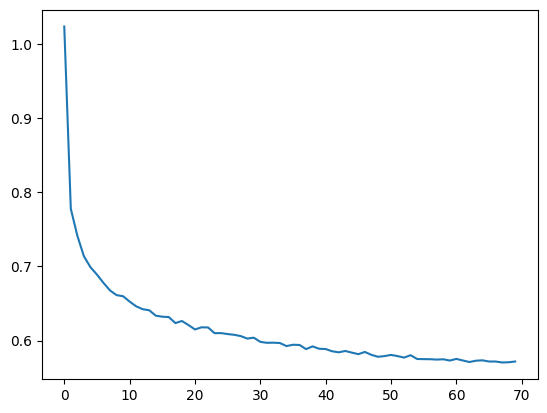

In [14]:
rounds = len(trainer.state.log_history) - 1
loss = [x["loss"] if i < rounds else None for i, x in enumerate(trainer.state.log_history)]
plt.plot(loss)

## Getting Embeddings 

In [16]:
val_df = pd.read_csv(f"/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/test.csv")
columns = val_df.columns.tolist()
ds = Dataset.from_pandas(val_df)

In [17]:
def combine_data_ordered(sample):
    concat = ""
    for col in columns:
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

def combine_data_shuffled(sample):
    concat = ""
    for col in random.sample(columns, k=len(columns)):
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

combined_ds = ds.map(combine_data_shuffled)
combined_ds["concat"][0]

Map: 100%|██████████| 22514/22514 [00:04<00:00, 4707.15 examples/s]


'seller_city is presidente prudente, customer_state is SP, customer_city is guarulhos, review_comment_message is Sem comentario, review_comment_title is Sem titulo, payment_installments is 1, seller_state is SP, price is 44.88, product_category is Furniture, payment_value is 64.11, review_score is 5, product_category_name is moveis_cozinha_area_de_servico_jantar_e_jardim, payment_type is credit_card, '

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

embs = []
for text in combined_ds["concat"]:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model(**inputs)

    # Extract logits
    logits = outputs.logits

    # Use logits as text embeddings
    text_embedding = logits[:, -1, :]  # Take the last token's logits as the embedding

    # Convert tensor to numpy array if needed
    text_embedding_np = text_embedding.detach().cpu().numpy()

    embs.append(text_embedding_np[0])

'''other option to do embds (not tested)
token_ids = tokenizer.encode("Your input text goes here", add_special_tokens=False)

# Convert token IDs to tensor and move it to the model's device
tokens_tensor = torch.tensor([token_ids], device=model.device)
with torch.no_grad():
# Forward pass through the model
outputs = model(tokens_tensor)
# Retrieve the hidden states from the model output
hidden_states = outputs[0]  # 'outputs' is a tuple, the first element is the hidden states

# Averaging over the sequence length
print(len((hidden_states[0].mean(dim=0))), (hidden_states[0].mean(dim=0)))
'''

'other option to do embds (not tested)\ntoken_ids = tokenizer.encode("Your input text goes here", add_special_tokens=False)\n\n# Convert token IDs to tensor and move it to the model\'s device\ntokens_tensor = torch.tensor([token_ids], device=model.device)\nwith torch.no_grad():\n# Forward pass through the model\noutputs = model(tokens_tensor)\n# Retrieve the hidden states from the model output\nhidden_states = outputs[0]  # \'outputs\' is a tuple, the first element is the hidden states\n\n# Averaging over the sequence length\nprint(len((hidden_states[0].mean(dim=0))), (hidden_states[0].mean(dim=0)))\n'

#### Saving embeddings

In [19]:
embedding_df = pd.DataFrame(embs)
embedding_df.to_csv(f'/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/{model_name.replace(".pt","").replace("/","")}_test_embeddings.csv', index=False)